In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
from os import listdir
import datetime
from pathlib import Path
from PIL import UnidentifiedImageError
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Num GPUs Available:  1


Reusing TensorBoard on port 6006 (pid 28164), started 8 days, 13:26:32 ago. (Use '!kill 28164' to kill it.)

In [2]:
#commonly used batch size
batch_size = 16

# Used to augment images, the below augmentations are used to augment the images and output as numeric data for machine learning
train_img_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    # splitting 20% of the training data into validation data
    validation_split=0.2,
    dtype=None
)
# gets all of the images and labels from the training folder and applies the above augmentations for the training subset of data
flowfromframeTrain = train_img_gen.flow_from_directory(
    directory='./input/train',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=SEED,
    save_to_dir=None,
    save_prefix='',
    save_format='',
    follow_links=False,
    subset='training',
    interpolation='nearest'
)
    
flowfromframeVal = train_img_gen.flow_from_directory(
    directory='./input/train',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=SEED,
    save_to_dir=None,
    save_prefix='',
    save_format='',
    follow_links=False,
    subset='validation',
    interpolation='nearest'
)

test_img_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None
)

flowfromframeTest = test_img_gen.flow_from_directory(
    directory='./input/test',
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    seed=SEED,
    save_to_dir=None,
    save_prefix='',
    save_format='',
    follow_links=False,
    interpolation='nearest'
)

Found 7462 images belonging to 16 classes.
Found 1859 images belonging to 16 classes.
Found 773 images belonging to 16 classes.


In [3]:
# VGG16 model is initialized here
# model = tf.keras.applications.vgg16.VGG16(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=22,
#     classifier_activation='softmax'
# )
input_shape=(224, 224, 3)

# model = tf.keras.applications.mobilenet.MobileNet(
#     input_shape=input_shape,
#     alpha=1.0,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#    pooling=None,
#    classes=16,
#    classifier_activation='softmax',
# )

# model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#     input_shape=input_shape,
#     alpha=1.0,
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     pooling=None,
#     classes=16,
#     classifier_activation='softmax',
# )

# model = tf.keras.applications.densenet.DenseNet121(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=input_shape,
#     pooling=None,
#     classes=16
# )

# model = tf.keras.applications.vgg16.VGG16(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=input_shape,
#     pooling=None,
#     classes=16,
#     classifier_activation='softmax'
# )

# model = tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=input_shape,
#     pooling=None,
#     classes=16
# )

model = tf.keras.Sequential([
  
   layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=input_shape),
   layers.MaxPooling2D(),
   layers.Conv2D(32, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Conv2D(64, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Flatten(),
   layers.Dense(128, activation='relu'),
   layers.Dense(16, activation='softmax')
 ])

learn_rate = (0.001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model_Callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
]

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./data/model',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)
model_Callbacks.append(model_checkpoint)

reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0001,
)
model_Callbacks.append(reduceLRCallback)

numStepsPerEpoch = flowfromframeTrain.total_batches_seen
history = model.fit(
    x=flowfromframeTrain,
    y=None,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    callbacks=model_Callbacks,
    validation_split=0.0,
    validation_data=flowfromframeVal,
    shuffle=False,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=flowfromframeTrain.samples/batch_size,
    validation_steps=25,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)




Epoch 1/20
466/466 [==============================] - 89s 176ms/step - loss: 2.3536 - accuracy: 0.2810 - val_loss: 1.7900 - val_accuracy: 0.4325
INFO:tensorflow:Assets written to: ./data\model\assets
Epoch 2/20
466/466 [==============================] - 63s 134ms/step - loss: 1.8819 - accuracy: 0.4122 - val_loss: 1.8124 - val_accuracy: 0.3950
Epoch 3/20
466/466 [==============================] - 59s 127ms/step - loss: 1.6840 - accuracy: 0.4741 - val_loss: 1.6447 - val_accuracy: 0.4975
INFO:tensorflow:Assets written to: ./data\model\assets
Epoch 4/20
466/466 [==============================] - 59s 127ms/step - loss: 1.5599 - accuracy: 0.5173 - val_loss: 1.4783 - val_accuracy: 0.5275
INFO:tensorflow:Assets written to: ./data\model\assets
Epoch 5/20
466/466 [==============================] - 59s 126ms/step - loss: 1.4595 - accuracy: 0.5464 - val_loss: 1.2982 - val_accuracy: 0.5925
INFO:tensorflow:Assets written to: ./data\model\assets
Epoch 6/20
466/466 [==============================] - 5

49/49 [==============================] - 3s 67ms/step - loss: 1.5757 - accuracy: 0.5420
              precision    recall  f1-score   support

           0       0.70      0.55      0.62        38
           1       0.38      0.42      0.40        38
           2       0.63      0.60      0.61        45
           3       0.55      0.51      0.53        43
           4       0.58      0.67      0.62        57
           5       0.69      0.74      0.72        46
           6       0.35      0.27      0.30        52
           7       0.44      0.51      0.47        41
           8       0.71      0.84      0.77        55
           9       0.33      0.33      0.33        40
          10       0.84      0.78      0.81        54
          11       0.46      0.48      0.47        56
          12       0.55      0.48      0.51        62
          13       0.40      0.63      0.49        54
          14       0.52      0.34      0.41        47
          15       0.56      0.40      0.47    

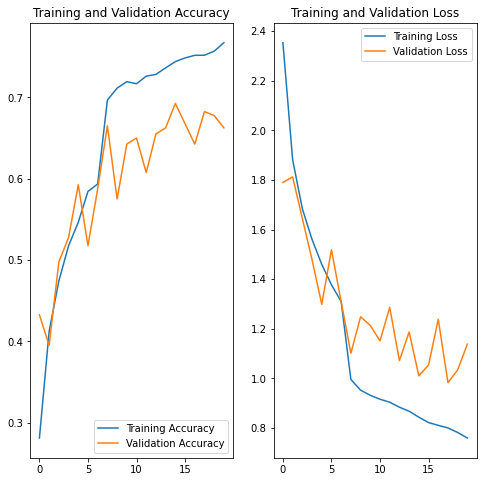

In [4]:
scores = model.evaluate(flowfromframeTest)


predictions = model.predict(flowfromframeTest)

test_labels = flowfromframeTest.labels

y_pred = np.argmax(predictions,axis=-1)

print(classification_report(test_labels, y_pred))

c_matrix = confusion_matrix(test_labels, y_pred)
print(c_matrix)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()